- Libraries

In [1]:
import pandas as pd
import numpy as np
from DateTime import DateTime

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")


- Selection of Data

In [2]:
df= pd.read_csv('../Data/apple.csv',sep=',',encoding='utf-8')
df= df[['Date','Close/Last']]
df['Close/Last']=df['Close/Last'].str.replace('$','',regex=False).astype(float)
df['Date']= pd.to_datetime(df['Date'])
df.sort_values(by='Date',inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index',inplace=True)


- Plotting the Data

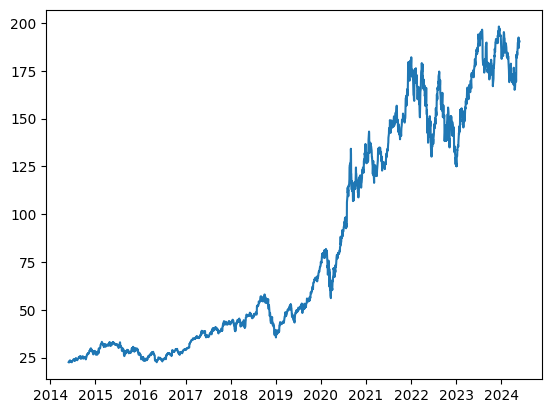

In [3]:
df.set_index('Date',inplace=True)
plt.plot(df.index, df['Close/Last'])


In [14]:
def transform_df(df,n_steps):
    
    for i in range(1,n_steps+1):
        df[f'Close (t-{i})']= df['Close/Last'].shift(i)
        
    df.dropna(inplace=True)
    return df

lookback= 7
data= transform_df(df,lookback)
df=df.asfreq('D')
df.ffill(inplace=True)
freq= pd.infer_freq(df.index)
data_array= df.to_numpy()


- Escalado de valores del array entre -1,1 para alimentar el modelo

In [20]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)

array([[-0.98869204, -0.99025863, -0.99446166, ..., -0.99772929,
        -1.        , -0.99823065],
       [-0.98980289, -0.98869204, -0.99025863, ..., -0.994767  ,
        -0.99638503, -1.        ],
       [-0.99427481, -0.98980289, -0.98869204, ..., -0.99373704,
        -0.99342473, -0.99638503],
       ...,
       [ 0.90737154,  0.87205195,  0.91785348, ...,  0.90611826,
         0.90583986,  0.90447357],
       [ 0.90748547,  0.90737154,  0.87205195, ...,  0.91944856,
         0.90618144,  0.90583986],
       [ 0.9109035 ,  0.90748547,  0.90737154, ...,  0.93437393,
         0.91950276,  0.90618144]])

- Haciendo Slicing para dividir el dato de entrenamiento y el target

In [21]:
X= transformed[:,1:]
y= transformed[:,0]
X= dc(np.flip(X,axis=1))
split_index= int(len(X) * 0.90)
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]
X_train= X_train.reshape((-1,lookback,1))
X_test= X_test.reshape((-1,lookback,1))
y_train= y_train.reshape((-1,1))
y_test= y_test.reshape((-1,1))
X_train= torch.tensor(X_train).float()
X_test= torch.tensor(X_test).float()
y_train= torch.tensor(y_train).float()
y_test= torch.tensor(y_test).float()

In [30]:
class TimeSeries(Dataset):
    def __init__(self,X,y):
        self.X= X
        self.y= y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i],self.y[i]
batch_size =16
train_dataset= TimeSeries(X_train,y_train)
test_dataset= TimeSeries(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [32]:
for _,batch in enumerate(train_loader):
    x_batch,y_batch= batch[0].to(device),batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size= hidden_size
        self.num_stacked_layers= num_stacked_layers
        
        self.lstm= nn.LSTM(input_size,hidden_size,num_stacked_layers,
                           batch_first=True)
        self.fc= nn.Linear(hidden_size,1)
        
    def forward(self,x):
        batch_size= x.size(0)
        h0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        
        out,_ = self.lstm(x,(h0,c0))
        out= self.fc(out[:,-1,:])
        return out
    
model= LSTM(1,4,1)
model.to(device)

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [34]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()
    
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [37]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    
    with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory

In [ ]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 25.79885544,  25.9142414 ,  25.99365556, ..., 167.28427754,
       167.40356096, 167.97461054])

In [ ]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 23.56249919,  23.46499973,  23.07250124, ..., 172.99000219,
       175.4299998 , 177.29999935])

In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([168.62761679, 168.97941422, 169.83448191, 170.54144062,
       170.71910758, 170.81390236, 170.57772107, 171.02007576,
       171.30252443, 172.00716035, 172.25691737, 172.59701717,
       173.21645289, 173.37955535, 173.52199863, 173.41432913,
       173.93623923, 174.1170294 , 173.98119351, 174.44505489,
       174.88615402, 175.2050767 , 176.22492617, 176.42406321,
       176.4330143 , 176.59868543, 176.4647015 , 176.038554  ,
       175.73627271, 175.80051553, 175.92753111, 176.01986185,
       176.65477757, 176.91068161, 177.36763741, 177.28880918,
       177.09717411, 177.1548357 , 177.32096721, 177.51325098,
       177.38514201, 177.78398108, 178.07139444, 178.11895924,
       177.65770838, 177.2127641 , 175.2663271 , 173.69237288,
       172.85840382, 171.87986227, 171.19195145, 170.68397806,
       170.66196914, 170.28801108, 169.97220638, 169.21636977,
       168.92494384, 168.99759891, 169.29248809, 170.21541879,
       169.72632066, 170.05617718, 170.57542444, 171.67

In [ ]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([177.25000191, 180.08999998, 180.95000098, 179.580002  ,
       179.20999896, 177.81999996, 180.57000054, 180.95999838,
       183.78999905, 183.30999849, 183.94999924, 186.01000163,
       184.91999775, 185.01000047, 183.96000186, 187.00000017,
       186.67999979, 185.27000077, 188.0600014 , 189.25000017,
       189.59000056, 193.97000042, 192.46000128, 191.33000258,
       191.80999791, 190.67999921, 188.60999942, 188.08000142,
       189.77000077, 190.53999905, 190.69000184, 193.99000044,
       193.73000014, 195.09999912, 193.12999944, 191.94000068,
       192.749999  , 193.6199974 , 194.49999842, 193.22000216,
       195.83000258, 196.44999807, 195.60500101, 192.58000142,
       191.1700024 , 181.99000219, 178.84999854, 179.80000226,
       178.18999777, 177.96999752, 177.79000254, 179.46000187,
       177.45000214, 176.57000112, 174.00000075, 174.4899987 ,
       175.83999766, 177.23000189, 181.11999856, 176.37999829,
       178.60999826, 180.1900001 , 184.12000205, 187.64

- El modelo puede claramente tener una idea de los patrones de los datos pero no de la escala
- El modelo se ha entrenado con datos muy antiguos que no tienen similitud con los datos actuales, habria que repetir el proceso de transformaciones y re-entrenar el modelo con datos mas recientes

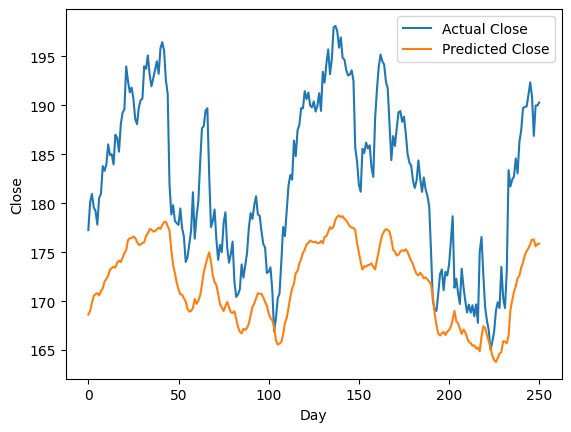

In [ ]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()